In [2]:
import os
# import tensorflow as tf
# tf.device('/gpu:3')
os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'

from numpy.random import seed
seed(42)
import tensorflow
tensorflow.random.set_seed(42)

# from tensorflow.python.client import device_lib 
# print(device_lib.list_local_devices())

In [3]:
## imports
# import tensorflow.compat.v1 as tf

# tf.disable_v2_behavior()
# libraries
import os
import numpy as np

# import matplotlib.pyplot as plt
from tqdm import tqdm
# custom

# import data_utilities

import tensorflow as tf
from tensorflow import keras

#import segmentation_models_3D as sm

# from skimage import io
# from patchify import patchify, unpatchify
import numpy as np
# from matplotlib import pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

import numpy as np
from numpy import load
import glob

def one_hot(mask):
    
    mask1=mask.copy()
    mask1=np.where(mask1==1,1,0)

    mask2=mask.copy()
    mask2=np.where(mask2==2,1,0)

    mask3=mask.copy()
    mask3=np.where(mask3==3,1,0)
    mask4=mask.copy()
    mask4=np.where(mask4==4,1,0)
    
    mask5=mask.copy()
    mask5=np.where(mask5==5,1,0)
    
    mask6=mask.copy()
    mask6=np.where(mask6==6,1,0)
    
    mask7=mask.copy()
    mask7=np.where(mask7==7,1,0)
    
    mask8=mask.copy()
    mask8=np.where(mask8>7,1,0)
    
    z, h, w = mask.shape
    onehot_vol = np.zeros((z, h, w,8), dtype=np.int8)
    
    onehot_vol[:,:,:,0]=mask1
    onehot_vol[:,:,:,1]=mask2
    onehot_vol[:,:,:,2]=mask3
    onehot_vol[:,:,:,3]=mask4
    onehot_vol[:,:,:,4]=mask5
    onehot_vol[:,:,:,5]=mask6
    onehot_vol[:,:,:,6]=mask7
    onehot_vol[:,:,:,7]=mask8
    return onehot_vol

In [2]:
"/home/minha/AIDA/total_crops/"
train_data_paths=glob.glob("/home/minha/AIDA/total_crops/training/images/*.npy")
train_masks_paths=glob.glob("/home/minha/AIDA/total_crops/training/masks/*.npy")


valid_data_paths=glob.glob("/home/minha/AIDA/total_crops/validation/images/*.npy")
valid_masks_paths=glob.glob("/home/minha/AIDA/total_crops/validation/masks/*.npy")


images_batch = []
masks_batch = []
flg = 0
for i in tqdm(range(len(train_data_paths))):
    
    mask = load(train_masks_paths[i])
#     temp=np.unique(mask)
# #     print(temp)
#     temp=np.where(temp==0.0,12.0,temp)
#     temp=np.where(temp>7.0,0.0,1.0)
    
    
#     if sum(temp)>1.:
    image = load(train_data_paths[i])

    image=image.reshape(128,128,128,1)

    images_batch.append(image)
    mask=one_hot(mask)
    masks_batch.append(mask)

        
images_valid = []
masks_valid = []


for i in tqdm(range(len(valid_data_paths))):
    
    mask = load(valid_masks_paths[i])
#     temp=np.unique(mask)
    
#     temp=np.where(temp==0.0,12.0,temp)
#     temp=np.where(temp>7.0,0.0,1.0)
    
#     if sum(temp)>1.:
    image = load(valid_data_paths[i])


#     images_batch.append(image)
    mask=one_hot(mask)
    image=image.reshape(128,128,128,1)

    images_valid.append(image)
    masks_valid.append(mask)

NameError: name 'glob' is not defined

In [3]:
masks_valid[0].shape

(128, 128, 128, 8)

In [4]:
# Loss Function and coefficients to be used during training:
# def dice_coefficient(y_true, y_pred):
#     smoothing_factor = 1
#     flat_y_true = K.flatten(y_true)
#     flat_y_pred = K.flatten(y_pred)
#     return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + smoothing_factor)
def dice_coe(y_true,y_pred, loss_type='jaccard', smooth=1.):

    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (2. * intersection + smooth) / (union + smooth)

# def dice_coefficient_loss(y_true, y_pred):
#     return 1 - dice_coefficient(y_true, y_pred)
def dice_loss(y_true,y_pred, loss_type='jaccard', smooth=1.):

    y_true_f = tf.cast(tf.reshape(y_true,[-1]),tf.float32)
    y_pred_f =tf.cast(tf.reshape(y_pred,[-1]),tf.float32)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (1-(2. * intersection + smooth) / (union + smooth))

#Define parameters for our model.

# encoder_weights = 'imagenet'
# BACKBONE = 'vgg16'  #Try vgg16, efficientnetb7, inceptionv3, resnet50
activation = 'sigmoid'
patch_size_x =128 #128# 128 160, 96, 64
patch_size_y =128 #96# 102
patch_size_z =128# 68
n_classes = 7
# channels=3
channels=1

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv3D, Input, MaxPooling3D, Dropout, concatenate, UpSampling3D, BatchNormalization
import tensorflow as tf

def Unet3D(inputs,num_classes):
    x=inputs
    conv1 = Conv3D(8, 3, activation = 'relu', padding = 'same',data_format="channels_last")(x)
    conv1= BatchNormalization()(conv1)
    conv1 = Conv3D(8, 3, activation = 'relu', padding = 'same')(conv1)
    conv1= BatchNormalization()(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
    conv2 = Conv3D(16, 3, activation = 'relu', padding = 'same')(pool1)
    conv2= BatchNormalization()(conv2)
    conv2 = Conv3D(16, 3, activation = 'relu', padding = 'same')(conv2)
    conv2= BatchNormalization()(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    conv3 = Conv3D(32, 3, activation = 'relu', padding = 'same')(pool2)
    conv3= BatchNormalization()(conv3)
    conv3 = Conv3D(32, 3, activation = 'relu', padding = 'same')(conv3)
    conv3= BatchNormalization()(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
    conv4 = Conv3D(64, 3, activation = 'relu', padding = 'same')(pool3)
    conv4= BatchNormalization()(conv4)
    conv4 = Conv3D(64, 3, activation = 'relu', padding = 'same')(conv4)
    conv4= BatchNormalization()(conv4)
    drop4 = Dropout(0.01)(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(drop4)

    conv5 = Conv3D(128, 3, activation = 'relu', padding = 'same')(pool4)
    conv5= BatchNormalization()(conv5)
    conv5 = Conv3D(128, 3, activation = 'relu', padding = 'same')(conv5)
    conv5= BatchNormalization()(conv5)
    drop5 = Dropout(0.01)(conv5)

    up6 = Conv3D(64, 2, activation = 'relu', padding = 'same')(UpSampling3D(size = (2,2,2))(drop5))
    up6= BatchNormalization()(up6)
    merge6 = concatenate([drop4,up6],axis=-1)
    conv6 = Conv3D(64, 3, activation = 'relu', padding = 'same')(merge6)
    conv6= BatchNormalization()(conv6)
    conv6 = Conv3D(64, 3, activation = 'relu', padding = 'same')(conv6)
    conv6= BatchNormalization()(conv6)

    up7 = Conv3D(32, 2, activation = 'relu', padding = 'same')(UpSampling3D(size = (2,2,2))(conv6))
    up7= BatchNormalization()(up7)
    merge7 = concatenate([conv3,up7],axis=-1)
    conv7 = Conv3D(32, 3, activation = 'relu', padding = 'same')(merge7)
    conv7= BatchNormalization()(conv7)
    conv7 = Conv3D(32, 3, activation = 'relu', padding = 'same')(conv7)
    conv7= BatchNormalization()(conv7)

    up8 = Conv3D(16, 2, activation = 'relu', padding = 'same')(UpSampling3D(size = (2,2,2))(conv7))
    up8= BatchNormalization()(up8)
    merge8 = concatenate([conv2,up8],axis=-1)
    conv8 = Conv3D(16, 3, activation = 'relu', padding = 'same')(merge8)
    conv8= BatchNormalization()(conv8)
    conv8 = Conv3D(16, 3, activation = 'relu', padding = 'same')(conv8)
    conv8= BatchNormalization()(conv8)

    up9 = Conv3D(8, 2, activation = 'relu', padding = 'same')(UpSampling3D(size = (2,2,2))(conv8))
    up9= BatchNormalization()(up9)
    merge9 = concatenate([conv1,up9],axis=-1)
    conv9 = Conv3D(8, 3, activation = 'relu', padding = 'same')(merge9)
    conv9= BatchNormalization()(conv9)
    conv9 = Conv3D(8, 3, activation = 'relu', padding = 'same')(conv9)
    conv9= BatchNormalization()(conv9)
#     conv10 = Conv3D(1, 1, activation = 'sigmoid')(conv9)
    conv10 = Conv3D(8, 1, activation = 'sigmoid')(conv9)
    model = Model(inputs=inputs, outputs = conv10)
    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [6]:
inputs = tf.keras.Input(shape=(patch_size_x,patch_size_y,patch_size_z, channels))

Model_3D = Unet3D(inputs,num_classes=n_classes)

In [5]:
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:1","/gpu:2"]) #
# mirrored_strategy=tf.distribute.MirroredStrategy()
# inputs = tf.keras.Input(shape=(patch_size_x,patch_size_y,patch_size_z, channels))
# Model_3D = Unet3D(inputs,num_classes=n_classes)
# Model_3D.compile(optimizer=optim, loss=dice_loss, metrics=[dice_coe])
# mirrored_strategy = tf.distribute.MirroredStrategy(devices= ["/gpu:1","/gpu:2"],cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
with mirrored_strategy.scope():
    inputs = tf.keras.Input(shape=(patch_size_x,patch_size_y,patch_size_z, channels))
    Model_3D = Unet3D(inputs,num_classes=n_classes)
    Model_3D.compile(optimizer=optim, loss=dice_loss, metrics=[dice_coe])
Model_3D.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

In [7]:
import os
import numpy as np
# import cv2
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K



def parse_image(img_path, image_size):
# def parse_image(img_rgb, image_size):
    image_rgb = np.load(img_path)
#     image_rgb=image_rgb[0:image_size,0:image_size,0:image_size]
    train_img = np.stack((image_rgb,)*3, axis=-1)
#     h, w, _ = image_rgb.shape
#     if (h == image_size) and (w == image_size):
#         pass
#     else:
#         image_rgb = cv2.resize(image_rgb, (image_size, image_size))
#     image_rgb = image_rgb/255.0
#     image_rgb = image_rgb.astype(np.float32)
    return train_img

def parse_mask(mask_path, image_size):
    mask = np.load(mask_path)
#     mask=mask[0:image_size,0:image_size,0:image_size]
    mask = np.where(mask==0,mask,1)
    train_mask = np.expand_dims(mask, axis=3)
#     h, w = mask.shape
#     if (h == image_size) and (w == image_size):
#         pass
#     else:
#         mask = cv2.resize(mask, (image_size, image_size))
#     mask = mask.astype(np.float32)
#     mask = np.expand_dims(mask, -1)
#     mask = mask/255.0

    return train_mask


class DataGen(Sequence):
    def __init__(self, image_size, images_path, masks_path, batch_size=8):
        self.image_size = image_size
        self.images_path = images_path
        self.masks_path = masks_path
        self.batch_size = batch_size
        self.on_epoch_end()

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.images_path):
            self.batch_size = len(self.images_path) - index*self.batch_size

        images_path = self.images_path[index*self.batch_size : (index+1)*self.batch_size]
        masks_path = self.masks_path[index*self.batch_size : (index+1)*self.batch_size]

        images_batch = []
        masks_batch = []

        for i in range(len(images_path)):
            image=images_path[i]
            mask=masks_path[i]
            images_batch.append(image)
            masks_batch.append(mask)
#         print(np.array(images_batch).shape)
#         print(np.array(masks_batch).shape)
            
        return np.array(images_batch), np.array(masks_batch)

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.images_path)/float(self.batch_size)))
    
    

In [7]:
image_size = 128
batch_size = 2

epochs = 100

train_steps = len(images_batch)//batch_size
valid_steps = len(images_valid)//batch_size

## Generator
train_gen = DataGen(image_size,images_batch,masks_batch, batch_size=batch_size)
valid_gen = DataGen(image_size,images_valid, masks_valid, batch_size=batch_size)

In [8]:
history=Model_3D.fit(train_gen,
                            validation_data=valid_gen,epochs=200,shuffle=True,batch_size=2)


Epoch 1/200
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:1 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:1 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:1 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:1 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:1 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/ta

Epoch 45/200
60/60 [==============================] - 17s 289ms/step - loss: 0.5436 - dice_coe: 0.4564 - val_loss: 0.4472 - val_dice_coe: 0.5528
Epoch 46/200
60/60 [==============================] - 17s 288ms/step - loss: 0.5174 - dice_coe: 0.4826 - val_loss: 0.4390 - val_dice_coe: 0.5610
Epoch 47/200
60/60 [==============================] - 17s 289ms/step - loss: 0.4922 - dice_coe: 0.5078 - val_loss: 0.4005 - val_dice_coe: 0.5995
Epoch 48/200
60/60 [==============================] - 17s 288ms/step - loss: 0.4662 - dice_coe: 0.5338 - val_loss: 0.3722 - val_dice_coe: 0.6278
Epoch 49/200
60/60 [==============================] - 17s 289ms/step - loss: 0.4409 - dice_coe: 0.5591 - val_loss: 0.3557 - val_dice_coe: 0.6443
Epoch 50/200
60/60 [==============================] - 17s 288ms/step - loss: 0.4179 - dice_coe: 0.5821 - val_loss: 0.3470 - val_dice_coe: 0.6530
Epoch 51/200
60/60 [==============================] - 17s 289ms/step - loss: 0.3928 - dice_coe: 0.6072 - val_loss: 0.3308 - val_di

KeyboardInterrupt: 

In [12]:
Model_3D.save('/home/usman/3D_model_8channels_Unet.h5')

AttributeError: 'Model' object has no attribute 'load'

In [11]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [12]:
acc = history.history['dice_coe']
val_acc = history.history['val_dice_coe']

plt.plot(epochs, acc, 'y', label='Training Dice coefficient')
plt.plot(epochs, val_acc, 'r', label='Validation Dice Coefficient')
plt.title('Training and validation Dice coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [8]:
from tensorflow.keras.models import load_model
my_model = load_model('/home/usman/3D_model_8channels_Unet.h5', compile=False)

In [9]:
test_data_paths=glob.glob("/home/minha/AIDA/total_crops/test/images/*.npy")
test_masks_paths=glob.glob("/home/minha/AIDA/total_crops/test/masks/*.npy")
images_test = []
masks_test = []
flg = 0
for i in tqdm(range(len(test_data_paths))):
    mask = load(test_masks_paths[i])
    temp=np.unique(mask)
    
    temp=np.where(temp==0.0,12.0,temp)
    temp=np.where(temp>7.0,0.0,1.0)
    
    if sum(temp)>1.:
    
        mask = load(test_masks_paths[i])
        image = load(test_data_paths[i])

        image=image.reshape(128,128,128,1)

        images_test.append(image)
        mask=one_hot(mask)
        masks_test.append(mask)

100%|██████████| 65/65 [00:11<00:00,  5.54it/s]


In [10]:
len(masks_test)

6

In [13]:
image_size = 128
batch_size = 1
test_gen = DataGen(image_size, images_test,masks_test, batch_size=batch_size)

In [16]:
y_pred=Model_3D.predict(test_gen,batch_size=2)
y_pred_argmax=np.where(y_pred>0.5,1,0)

In [14]:
def compute_dice(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

In [15]:
dice=[]
for k in range(len(images_test)):
    try:
        y_pred=my_model.predict(test_gen.__getitem__(k)[0])
        y_pred_argmax=np.where(y_pred>0.5,1,0)
        true_msk=test_gen.__getitem__(k)[1]
        dice.append(compute_dice(y_pred_argmax, true_msk))
    except:
        print(k)

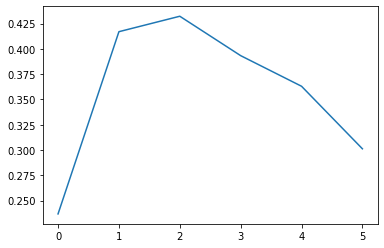

In [60]:
import matplotlib.pyplot as plt
plt.plot(dice) #, label='Test Dice coefficient'
plt.show()

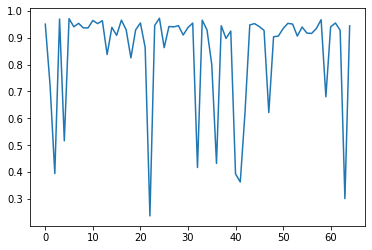

In [21]:
import matplotlib.pyplot as plt
plt.plot(dice) #, label='Test Dice coefficient'
plt.show()

In [ ]:
dice=np.asarray(dice)

In [62]:
np.mean(dice)

0.3572978710757398

In [30]:
y_pred_argmax[0][:,:,50,4].shape

(128, 128)

In [32]:
np.unique(y_pred_argmax)

array([0, 1])

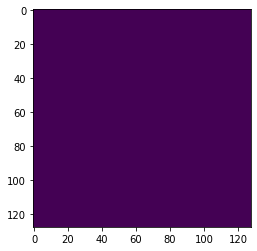

In [31]:
plt.imshow(y_pred_argmax[0][:,:,50,3])

In [16]:
import numpy as np
import ipywidgets as ipyw
import matplotlib.pyplot as plt
%matplotlib inline

class ImageSliceViewer3D:
    """ 
    ImageSliceViewer3D is for viewing volumetric image slices in jupyter or
    ipython notebooks. 
    
    User can interactively change the slice plane selection for the image and 
    the slice plane being viewed. 

    Argumentss:
    Volume = 3D input image
    figsize = default(8,8), to set the size of the figure
    cmap = default('plasma'), string for the matplotlib colormap. You can find 
    more matplotlib colormaps on the following link:
    https://matplotlib.org/users/colormaps.html
    
    """
    
    def __init__(self, volume, figsize=(8,8), cmap='gray'):
        self.volume = volume
        self.figsize = figsize
        self.cmap = cmap
        self.v = [np.min(volume), np.max(volume)]
        
        # Call to select slice plane
        ipyw.interact(self.view_selection, view=ipyw.RadioButtons(
            options=['x-y','y-z', 'z-x'], value='x-y', 
            description='Slice plane selection:', disabled=False,
            style={'description_width': 'initial'}))
    
    def view_selection(self, view):
        # Transpose the volume to orient according to the slice plane selection
        orient = {"y-z":[1,2,0], "z-x":[2,0,1], "x-y": [0,1,2]}
        self.vol = np.transpose(self.volume, orient[view])
        maxZ = self.vol.shape[2] - 1
        
        # Call to view a slice within the selected slice plane
        ipyw.interact(self.plot_slice, 
            z=ipyw.IntSlider(min=0, max=maxZ, step=1, continuous_update=False, 
            description='Image Slice:'))
        
    def plot_slice(self, z):
        # Plot slice for the given plane and slice
        self.fig = plt.figure(figsize=self.figsize)
        plt.imshow(self.vol[:,:,z], cmap=plt.get_cmap(self.cmap), 
            vmin=self.v[0], vmax=self.v[1])
        
        


In [17]:
vol=np.amax(y_pred_argmax[0][:,:,:,:-2],axis=(3))

In [26]:
vol=np.amax(y_pred_argmax[0][:,:,:,:],axis=(3))

In [37]:
vol=np.amax(true_msk[0][:,:,:,:],axis=(3))
vol=true_msk[0][:,:,:,4]

In [64]:
np.unique(vol)

array([0, 1])

In [38]:
ImageSliceViewer3D(vol)

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [24]:
org=test_gen.__getitem__(k)[0][0].reshape(128,128,128)

In [25]:
ImageSliceViewer3D(org)

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [ ]:
k=25#15,23,9,10,20,2111#8#good5,12,18,x14,19#2#1 
y_pred=my_model.predict(test_gen,batch_size=2)
y_pred_argmax=np.where(y_pred>0.5,1,0)

In [ ]:
true_msk=test_gen.__getitem__(k)[1]

In [ ]:
print(np.unique(y_pred_argmax),np.unique(true_msk))

In [ ]:
dice = compute_dice(y_pred_argmax, true_msk)

print('Dice:{:.2f}'.format(dice))

In [ ]:
# plt.imshow(test_gen.__getitem__(k)[0][0,:,:,10])
# plt.show()

In [ ]:
plt.imshow(true_msk[0,:,:,10,0],'gray')
plt.show()

In [ ]:
plt.imshow(y_pred_argmax[0,:,:,10,0],'gray')
plt.show()